In [1]:
#import required modules

import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [2]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)

random_sample = 1

# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

# Split the data into testing, training and validation data
# As using a random sample = 1, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)

images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Classes are ['no' 'yes']
Preparing testing data


In [3]:
model_A = keras.models.load_model("97%.h5")

In [4]:
#model_A.summary()

In [5]:
labels

[array([1, 0], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0], dtype=uint8),
 array([0, 1], dtype=uint8),
 array([1, 0],

In [6]:
temp_model=tf.keras.Model(model_A.input,model_A.layers[-2].output)
final_layers = temp_model.predict(np.stack(images))
predictions = model_A.predict(np.stack(images))
pred_array = [[0,1][np.argmax(individual_result)] for individual_result in predictions]

2/2 [==============================] - 4s 466ms/step


In [7]:
from sklearn.manifold import TSNE

projections = TSNE(2,random_state=1).fit_transform(final_layers)

In [8]:
print(pred_array)
print(labels)

[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
[array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([0, 1], dt

Text(0.5, 1.0, 't-SNE Dimension Analysis')

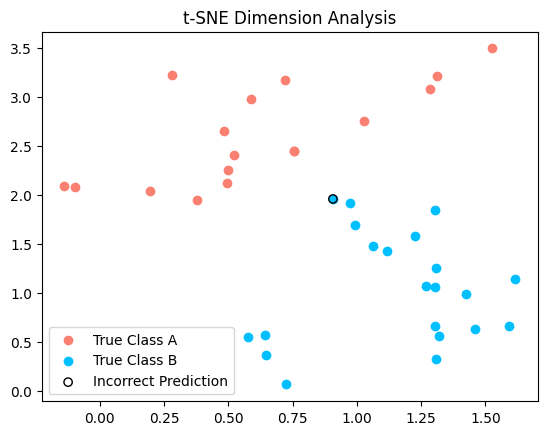

In [9]:
true_class_A_projections = []
true_class_B_projections = []
incorrect_preds_projections = []

for proj,lab,pred in zip(projections,labels,pred_array):

    if pred == lab[0]:
        incorrect_preds_projections.append(proj)

    if lab[0] == 1:
        true_class_A_projections.append(proj)
    else:
        true_class_B_projections.append(proj)
        
plt.scatter([x[0] for x in true_class_A_projections],[x[1] for x in true_class_A_projections],color="salmon",label = "True Class A")
plt.scatter([x[0] for x in true_class_B_projections],[x[1] for x in true_class_B_projections],color="deepskyblue",label="True Class B")
plt.scatter([x[0] for x in incorrect_preds_projections],[x[1] for x in incorrect_preds_projections],alpha=1,facecolor="None",edgecolors="black",label="Incorrect Prediction")
plt.legend()

plt.title("t-SNE Dimension Analysis")

In [10]:
labels = [label[1] for label in y_test] # 0 if no tumour, 1 if yes tumour

initial_df = pd.DataFrame()
initial_df["class"] = labels # 0 if no tumour, 1 if there is a tumour
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in predictions]
initial_df["confidence_class_1"] = [alpha[1] for alpha in predictions]

In [11]:
class_zero_df = initial_df[initial_df["class"] == 0] # no tumour
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)
class_zero_length = len(class_zero_df)

In [12]:
muba_df = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image",
                    "y_value_class_1",
    ])

In [13]:
MUBA_ITERS = 60

# Iterate through NO tumour images
for index0, row0 in class_zero_df.iterrows():
    
    # Iterate through YES tumour images
    for index1, row1 in class_one_df.iterrows():

        for i in range(MUBA_ITERS):
            
            # Mixup images
            lam = (1/MUBA_ITERS) * np.random.rand() + ( (i) / MUBA_ITERS)
            new_img = lam * images[int(row0["image_index"])] + (1 - lam) * images[int(row1["image_index"])]

            row = pd.DataFrame([({ "alpha_class_0": lam, # row 0 is multiplied by lam
                    "alpha_class_1": 1-lam,
                    "image": new_img,
                    "y_value_class_1": (row1["confidence_class_1"] - row0["confidence_class_1"]) * (1-lam) + row0["confidence_class_1"], # Confidence in yes, there is a tumour
                    })])
            
            
            muba_df = pd.concat([muba_df, row],axis=0, ignore_index=True)



In [14]:
all_mixed_up_images = muba_df["image"]

muba_prediction = model_A.predict(np.stack(all_mixed_up_images))


670/670 [==============================] - 1996s 3s/step


In [15]:
muba_final_layers = temp_model.predict(np.stack(all_mixed_up_images))

670/670 [==============================] - 2063s 3s/step


In [16]:

muba_projections = TSNE(2,random_state=1).fit_transform(muba_final_layers)

In [17]:
muba_prediction_proper = [[0,1][np.argmax(individual_result)] for individual_result in muba_prediction]

In [27]:
muba_labels = []
muba_true_alpha_A = []
muba_true_alpha_B = []
muba_incorrect = []

for proj,alpha,pred in zip(muba_projections,muba_df["alpha_class_1"],muba_prediction_proper):
    a = round(alpha)

    if a != pred:
        muba_incorrect.append(proj)

    if a == 1:
        muba_true_alpha_A.append(proj)
    else:
        muba_true_alpha_B.append(proj)

Text(0.5, 1.0, 't-SNE Dimension Analysis')

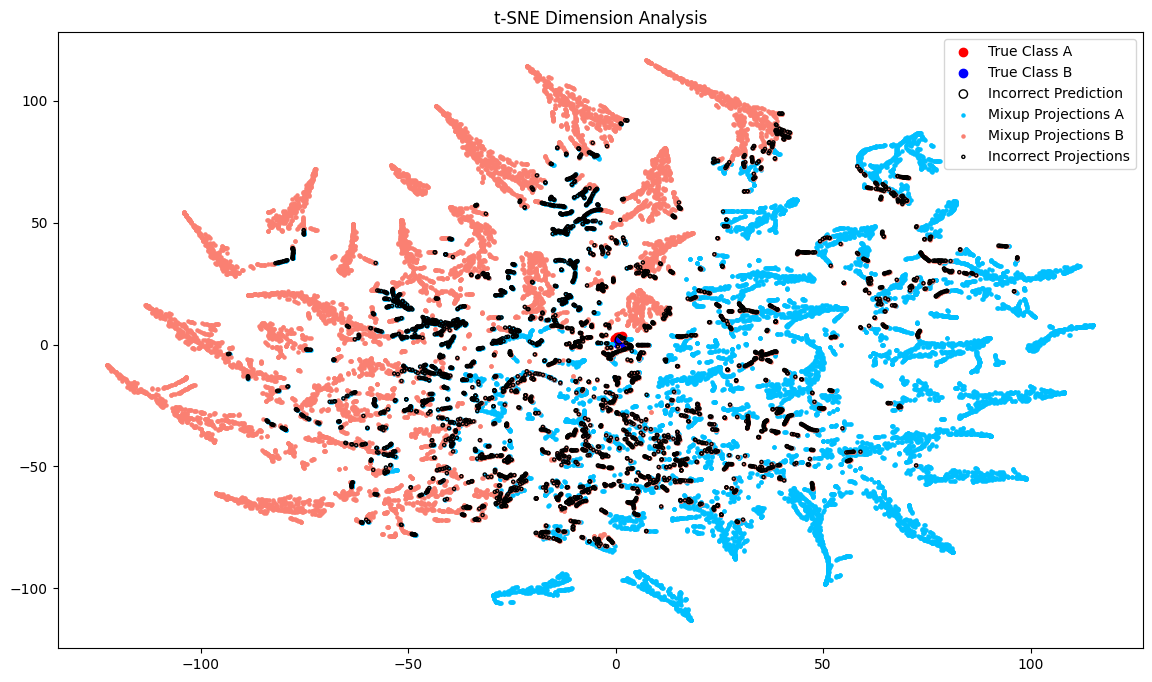

In [58]:
plt.figure(figsize=(14,8))

plt.scatter([x[0] for x in true_class_A_projections],[x[1] for x in true_class_A_projections],color="red",label = "True Class A")
plt.scatter([x[0] for x in true_class_B_projections],[x[1] for x in true_class_B_projections],color="blue",label="True Class B")
plt.scatter([x[0] for x in incorrect_preds_projections],[x[1] for x in incorrect_preds_projections],alpha=1,facecolor="None",edgecolors="black",label="Incorrect Prediction")


plt.scatter([x[0] for x in muba_true_alpha_A],[x[1] for x in muba_true_alpha_A],marker = "o",s=5,label = "Mixup Projections A", color = "deepskyblue")
plt.scatter([x[0] for x in muba_true_alpha_B],[x[1] for x in muba_true_alpha_B],marker = "o",s=5,label = "Mixup Projections B", color = "salmon")
plt.scatter([x[0] for x in muba_incorrect],[x[1] for x in muba_incorrect],marker="o",alpha=1,s=5,facecolor="None",edgecolors="black",label="Incorrect Projections")


plt.legend()

plt.title("t-SNE Dimension Analysis")

# lim = 8
# plt.xlim(-lim,lim)
# plt.ylim(-lim,lim)